### APAN5420 Anomaly Detection - Assignment 11

### Name: Kanyarat Suwannama

# Data preparation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

import datetime

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Use Pandas to do data preparation

In [2]:
data = pd.read_csv("XYZloan_default_selected_vars.csv")

In [3]:
# Let's take a look at our target variable:
data['loan_default'].value_counts()

0    64512
1    15488
Name: loan_default, dtype: int64

<AxesSubplot:>

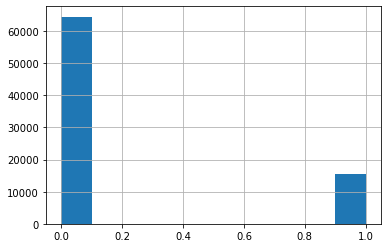

In [4]:
data['loan_default'].hist()

In [5]:
features = ['loan_default','AP001', 'AP003', 'AP008', 'CR009', 'CR015', 'CR019', 'PA022', 'PA023', 'PA029', 'TD001', 'TD005', 'TD006', 'TD009', 'TD010', 'TD014']
df = data[features]

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values_per = (df.isnull().sum() / df.isnull().count())
pd.concat([missing_values, missing_values_per],axis=1, keys = ['Count_of_Missing','Percentage'])

,Count_of_Missing,Percentage
loan_default,0,0.000000
AP001,0,0.000000
AP003,0,0.000000
AP008,0,0.000000
CR009,0,0.000000
CR015,0,0.000000
CR019,0,0.000000
PA022,381,0.004763
PA023,381,0.004763
PA029,381,0.004763


In [7]:
r = pd.concat([missing_values, missing_values_per],axis=1, keys = ['Count_of_Missing','Percentage']).reset_index()
r

,index,Count_of_Missing,Percentage
0,loan_default,0,0.000000
1,AP001,0,0.000000
2,AP003,0,0.000000
3,AP008,0,0.000000
4,CR009,0,0.000000
5,CR015,0,0.000000
6,CR019,0,0.000000
7,PA022,381,0.004763
8,PA023,381,0.004763
9,PA029,381,0.004763


In [8]:
def null_cell(df):
    dfx = df.copy()
    missing_values = dfx.isnull().sum()
    missing_values_per = dfx.isnull().sum() / dfx.isnull().count()
    null_values = pd.concat([missing_values, missing_values_per],axis=1, keys = ['the_null','the_null_perc'])
    null_values = null_values.sort_values('the_null',ascending=False)
    return null_values[null_values['the_null']>0]

fill_list = (null_cell(df)).index
fill_list

Index(['PA022', 'PA023', 'PA029'], dtype='object')

In [9]:
r.loc[r['index']=='type','Percentage']

Series([], Name: Percentage, dtype: float64)

In [10]:
for col in fill_list:
    df.loc[:,col].fillna(df.loc[:,col].mean(),inplace=True)

# Explain Model with the SHAP Values  Random Forest Model

SHAP values are used whenever there is a complex model and there is a need to understand what decisions the model is making. SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction made if that feature took some baseline value.

In order to asess these values, we are going to visualize the following plots:

* The summary_plot
* The dependence_plot
* The force_plot for 4 individual observations

### Model 1 -  Random Forest Model

In [11]:
# Let's pick the predictors and the target
predictors = df[['AP001','AP003','AP008','CR009', 'CR015', 'CR019','PA022', 'PA023', 'PA029',
             'TD001', 'TD005', 'TD006', 'TD009', 'TD010', 'TD014']]
target = df['loan_default']

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(predictors, target, test_size = 0.2)

In [13]:
# Define the features with WOE transformation and target variable
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)  
print(model.feature_importances_)

[0.01478171 0.21353968 0.0142793  0.03283767 0.06605648 0.00969396
 0.03897866 0.03723515 0.06417402 0.01752302 0.05607095 0.01731709
 0.34881605 0.01712156 0.05157471]


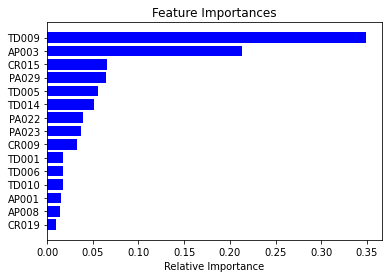

In [14]:
# Let's see the importance of the variables:
importances = model.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### The summary_plot

The graph below plots the SHAP values of every feature for every sample. It shorts features by the total of absolute SHAP values over all samples. The color represents the feature value (red high, blue low).

- The vertical location shows the feature importance.
- The horizontal location shows whether the effect of that value caused a higher or lower prediction.
- Color shows whether that feature was high or low for that observation

A variable importance plot lists the most significant variables in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power.

In [15]:
import shap

In [16]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)

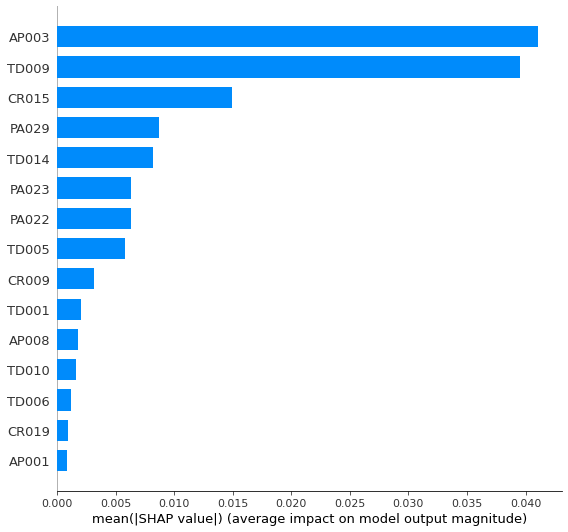

In [17]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

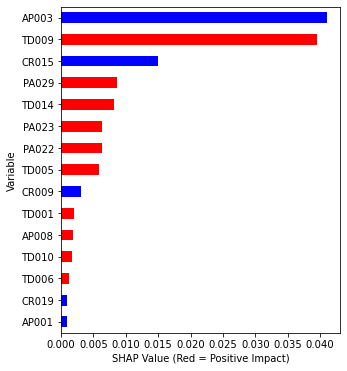

In [18]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)

The SHAP value plot can show the positive and negative relationships of the predictors with the target variable. It delivers the following information:

- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: The “high” comes from the red color, and the “positive” impact is shown on the X-axis.

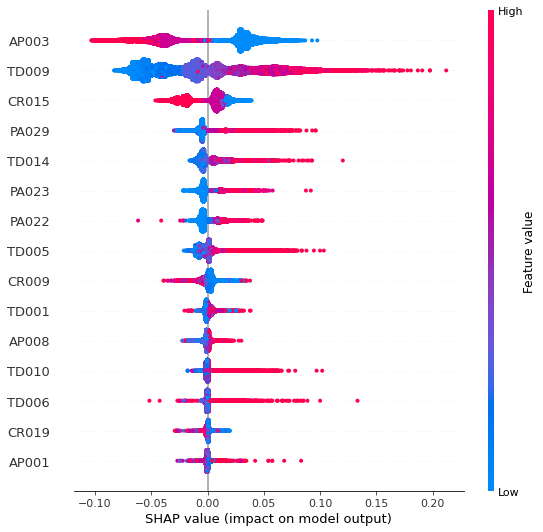

In [19]:
shap.summary_plot(shap_values, X_train)

We can describe the model. A high loan default is associated with the following characteristics:
* Low  AP003 
* High TD009 
* Low  CR015 
* High PA029
* High TD014 
* High TD005
* High PA023
* High PA022
* High CR009
* High TD001
* High TD006
* High AP008
* Low  CR019
* High AP001
* High TD010

AP003 is the most important feature, it inversely correlated to the outcome. Higher the value lower the risk of default.

We can see that TD009 is the second most important feature. It is positively correlates with the prediction, majority of the high values in this feature are associated with a high SHAP value.This could imply that higher the TD009 value could have higher chances of default. Non Fradulant activity can be associated with lower TD009 values. 

The impact of some of the variable is centred around zero and need to be better explored and re-evaluated while modelling

### The dependence_plot

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Hence, Lets plot the dependance plot for some the variables to highlight their impact on the outcome and their relationship to another variable.

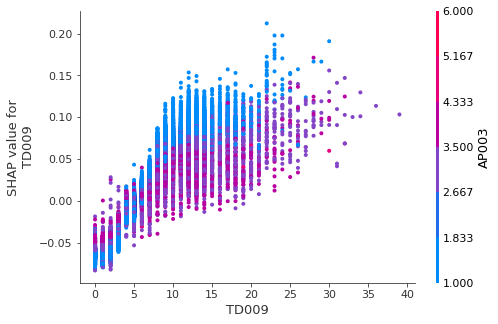

In [20]:
shap.dependence_plot("TD009", shap_values, X_train)

The plot shows there is an approximately linear and positive trend between TD009 and the target variable, and TD009 interacts with AP003 frequently.

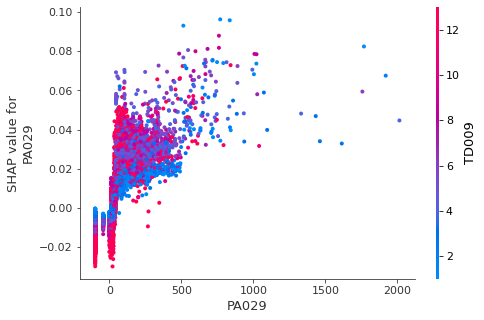

In [21]:
shap.dependence_plot("PA029", shap_values, X_train)

This is a clear example where no strong insight can be derived. Interaction effect with PA029 is not very obvious. This is one variable that may be removed from the training set, since it may confound the model.

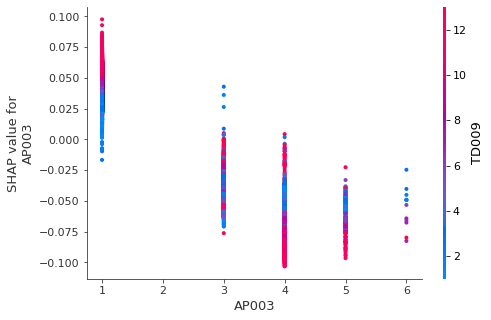

In [22]:
shap.dependence_plot("AP003", shap_values, X_train)

We observe that this is not a continuous variable. It has discrete levels, which are associated with certain SHAP values/ output variable. We can see that there is a general linearly negative trend. Lower values of AP003 have lower chance of defaulting and vice versa. The interacting variable here is TD009. We can see that for AP004 = 4, and a low value of TD009, SHAP values are low and hence have lower chance of default.

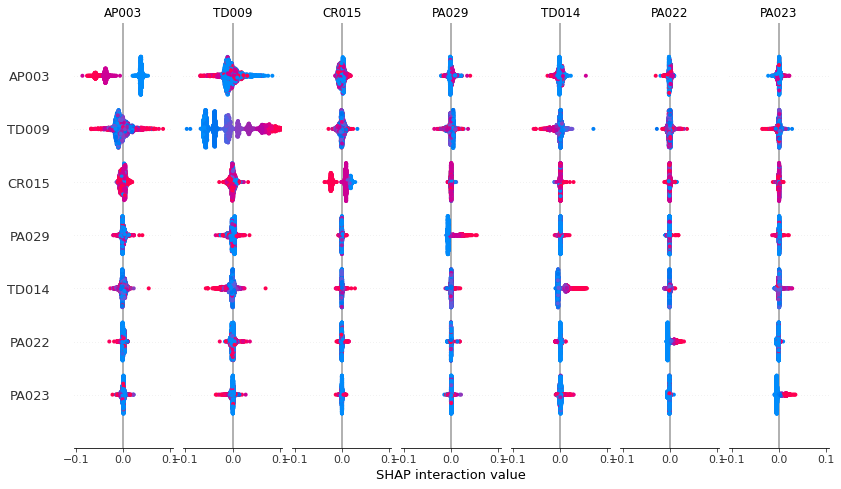

In [23]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_train.iloc[:2000,:])

shap.summary_plot(shap_interaction_values, X_train.iloc[:2000,:])

### The force_plot for 4 individual observations

The SHAP force plot shows you exactly which features had the most influence on the model’s prediction for a single observation. While the above two types of plots indicate the global interpretability(gives insights about features), force plots give us insights on impact of features on individual instances.shap.initjs()

In [24]:
# Individual SHAP Value Plot — Local Interpretability
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)

random_picks = np.arange(1,330,50)
S = X_output.iloc[random_picks]
S

,AP001,AP003,AP008,CR009,CR015,CR019,PA022,PA023,PA029,TD001,TD005,TD006,TD009,TD010,TD014,predict
13415,31,3,3,54000,6,5,-1.000000,-1.000000,-98.000000,2,5,2,11,4,5,0.16
4550,45,1,5,77000,5,11,90.000000,90.000000,113.000000,0,2,1,2,2,5,0.24
70814,25,1,5,10519,4,3,-1.000000,-1.000000,-98.000000,3,5,2,7,3,3,0.28
128,26,3,3,14000,2,3,-1.000000,-1.000000,-98.000000,0,2,0,2,0,0,0.11
33743,33,1,3,22399,5,5,77.000000,77.000000,113.000000,2,2,1,3,5,5,0.30
46331,38,3,2,0,6,5,82.000000,-1.000000,18.000000,2,2,0,3,1,1,0.11
50854,29,1,4,13700,6,6,19.298811,14.828822,-42.407356,0,0,0,3,1,1,0.15


In [25]:
shap.initjs()

In [26]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [27]:
X_train.mean()

AP001       31.702891
AP003        2.013781
AP008        3.118578
CR009    35156.662328
CR015        4.922797
CR019        6.200938
PA022       19.283939
PA023       14.824173
PA029      -42.309304
TD001        1.987391
TD005        3.593672
TD006        1.345266
TD009        5.401953
TD010        2.020062
TD014        2.600578
dtype: float64

In [28]:
Y_test.mean()

0.190125

In [29]:
# When I execute shap_plot(0) I get the result for the first row in Table above
shap_plot(0)

The output value of the 1st prediction is 0.16 and base value is 0.1951. TD009 has a positive impact on the loan default. A higher than the average TD009 (=11 > 5.41) drives the prediction to the right. AP003 has a negative impact on the loan default. A higher than the average AP003 (=3 > 2.01) drives the prediction to the left. 

In [30]:
# Now we can see the result of the rest of the rows. 
shap_plot(1)

The output value of the 2nd prediction is 0.24 and the base value is 0.1951. AP003 has a negative impact on the loan default. A lower than the average AP003 (=1 < 2.01) drives the prediction to the right. TD009 has a positive impact on the loan default. A lower than the average TD009 (=2 < 5.41) drives the prediction to the left. 

In [31]:
shap_plot(2)

The output value of the 3nd prediction is 0.28 and the base value is 0.1951. AP003 has a negative impact on the loan default. A lower than the average AP003 (=1 < 2.01) drives the prediction to the right. PA029 has a positive impact on the loan default. A lower than the average PA029 (=-98 < -42.58) drives the prediction to the left.

In [32]:
shap_plot(3)

The output value of the 4th prediction is 0.11 and the base value is 0.1951. CR015 has a negative impact on the loan default. A lower than the average CR015 (=2 < 4.93) drives the prediction to the right. TD009 has a positive impact on the loan default. A lower than the average TD009 (=2 < 5.41) drives the prediction to the left.

### Model 2 - H2O Random Forest Model

In [33]:
train = pd.concat([X_train, Y_train], axis=1)
len(train)

64000

In [34]:
test = pd.concat([X_test, Y_test], axis=1)
len(test)

16000

In [35]:
# Binning the test and train dataset
def binning(var, train, test):
    # Define the extreme values 
    extreme_val = [-99,-98,-1]
    
    # Fit the extreme values into single category
    train.loc[train[var]==-99, var+'_bin']=-99
    train.loc[train[var]==-1, var+'_bin']=-1
    train.loc[train[var]==-98, var+'_bin']=-98
    
    # Separate the dataset into two parts based on whether the values of a variable are in a list of extreme values
    special_train = train.loc[train[var].isin(extreme_val)]
    normal_train = train.loc[-train[var].isin(extreme_val)]
    
    # Transfer the continuous variable to categorical binned variables 
    s, b = pd.qcut(normal_train[var], 10, duplicates='drop', retbins=True)

    normal_train[var+'_bin'] = pd.cut(normal_train[var], bins=b, duplicates='drop').astype(str)
    
    # Recombine the data
    train=pd.concat([special_train, normal_train], axis=0)
    
    # Put the extreme value in specific categories
    test.loc[test[var]==-99, var+'_bin']=-99
    test.loc[test[var]==-1, var+'_bin']=-1
    test.loc[test[var]==-98, var+'_bin']=-98
    
    # Separate the dataset into two parts based on whether the values of a variable are in a list of extreme values
    special_test = test.loc[test[var].isin(extreme_val)]
    normal_test = test.loc[-test[var].isin(extreme_val)]
    
    # Use the binning range in train dataset to cut the test data
    # Return the list of the bins in training data set and applied it into test set
    normal_test[var+'_bin'] = pd.cut(normal_test[var], bins=b, duplicates='drop').astype(str)
    
    # Recombine the data
    test=pd.concat([special_test, normal_test], axis=0)
    
    # Categorize NA in a new category -- 'NoData'
    train[var+'_bin'] = train[var+'_bin'].fillna('NoData')
    test[var+'_bin'] = test[var+'_bin'].fillna('NoData')

    return train, test

# Apply the binning function to each predictor variable
for i in predictors:
    train, test = binning(i, train, test)

# Create a list of the binned predictor variable names
features_bin = [f + '_bin' for f in predictors]
features_bin

['AP001_bin',
 'AP003_bin',
 'AP008_bin',
 'CR009_bin',
 'CR015_bin',
 'CR019_bin',
 'PA022_bin',
 'PA023_bin',
 'PA029_bin',
 'TD001_bin',
 'TD005_bin',
 'TD006_bin',
 'TD009_bin',
 'TD010_bin',
 'TD014_bin']

In [36]:
# Create WOE function
def WOE(var, train):
    train[var] = train[var].fillna('NoData')
    k = train[[var,'loan_default']].groupby(var)['loan_default'].agg(['count','sum']).reset_index()
    k.columns = [var,'Count','Good']
    k['Bad'] = k['Count'] - k['Good']
    k['Good %'] = (k['Good'] / k['Good'].sum()*100).round(2)
    k['Bad %'] = (k['Bad'] / k['Bad'].sum()*100).round(2)
    k[var+'_WOE'] = np.log(k['Good %'] / k['Bad %']).round(2)
    k = k.sort_values(by=var+'_WOE')
    
    return(k)

In [37]:
for f in features_bin:
    try:
        k = WOE(f, train)
        train[f+'_WOE'] = train[f].map(k.set_index(f)[f+'_WOE'])
        train[f+'_WOE'] = train[f+'_WOE'].fillna(k[f+'_WOE'].iloc[-1])
        test[f+'_WOE'] = test[f].map(k.set_index(f)[f+'_WOE'])
        test[f+'_WOE'] = test[f+'_WOE'].fillna(k[f+'_WOE'].iloc[-1])
        #Merge WOE variable from training dataset to test dataset
        test[f+'_WOE'] = test[f+'_WOE'].fillna(train[f+'_WOE'].iloc[-1])
    except:
        pass

In [38]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [39]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 days 0 hours 14 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_kanyaratsuwannama_jenijr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.637 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [40]:
#h2o.cluster().shutdown()

In [41]:
predictors = ['AP001_bin_WOE', 'AP003_bin_WOE', 'AP008_bin_WOE', 'CR009_bin_WOE', 'CR015_bin_WOE', 'CR019_bin_WOE', 'PA022_bin_WOE', 'PA023_bin_WOE', 'PA029_bin_WOE', 'TD001_bin_WOE', 'TD005_bin_WOE', 'TD006_bin_WOE', 'TD009_bin_WOE', 'TD010_bin_WOE', 'TD014_bin_WOE']
target = 'loan_default'

In [42]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [43]:
from h2o.estimators import H2ORandomForestEstimator
# Build and train the model:
rf = H2ORandomForestEstimator(ntrees=100, max_depth=6, min_rows=10)
rf.train(x=predictors, y=target, training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1681234149969_8


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         73828                  6            6            6             41            62            54.08

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.15009812300962846
RMSE: 0.3874249901718118
MAE: 0.3006916709468297
RMSLE: 0.27172115456668416
Mean Residual Deviance: 0.15009812300962846

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-04-13 13:43:30  0.009 sec   0.0                nan                  nan                  nan
     2023-04-13 13:43:30  0.017 sec   1.0                0.40036261501973064  0.30279049773848654  0.16029022350543704
     2023-04-13 13:43:30  0.022 sec   2.0                0.4003383495189796   0.3029490679285106   0.1602707940955807
     2023-04-13 13:43:30  0.029 sec   3.0                0.402358842324716    0.30438869351869907  0.1618926379968857
     2023-04-13 13:43:30  0.037 sec   4.0                0.399917955600265    0.3037221607492435   0.15993437121149554
     2023-04-13 13:43:30  0.041 sec   5.0                0.3991778537111926   0.3034868303950975   0.15934295889347427
     2023-04-13 13:43:30  0.045 sec   6.0                0.3969513044292441   0.30309403991014017  0.15757033808807844
     2023-04-13 13:43:30  0.049 sec   7.0                0.39512050301723034  0.30269838906908453  0.15612021190458913
     2023-04-13 13:43:30  0.052 sec   8.0                0.39444825346743234  0.3026234761859164   0.15558942466350775
     2023-04-13 13:43:30  0.057 sec   9.0                0.39300478110266557  0.30171632644703034  0.1544527579695541
---  ---                  ---         ---                ---                  ---                  ---
     2023-04-13 13:43:30  0.827 sec   91.0               0.3875004010705427   0.3008089041246931   0.15015656082983145
     2023-04-13 13:43:30  0.842 sec   92.0               0.38749065437618035  0.30074840562946936  0.15014900722888044
     2023-04-13 13:43:30  0.847 sec   93.0               0.3874828304000906   0.30074127096104386  0.1501429438548654
     2023-04-13 13:43:30  0.851 sec   94.0               0.3874398620755317   0.3007294668933154   0.15010964672510704
     2023-04-13 13:43:30  0.855 sec   95.0               0.3874803987798856   0.3007706075453331   0.15014105943861916
     2023-04-13 13:43:30  0.859 sec   96.0               0.3874817544625275   0.30078115053459864  0.15014211004135844
     2023-04-13 13:43:30  0.862 sec   97.0               0.3874709919807714   0.30078726089776736  0.150133769626563
     2023-04-13 13:43:30  0.867 sec   98.0               0.38743208748754093  0.3007620208281196   0.15010362241495356
     2023-04-13 13:43:30  0.871 sec   99.0               0.38740078641963877  0.30071517544253906  0.15007936931855456
     2023-04-13 13:43:30  0.875 sec   100.0              0.3874249901718118   0.3006916709468297   0.15009812300962846
[101 rows x 7 columns]


Variable Importances: 
variable       relative_importance    scaled_importance    percentage
-------------  ---------------------  -------------------  ------------
TD009_bin_WOE  1077.83                1                    0.1797
TD014_bin_WOE  676.281                0.627449             0.112752
AP003_bin_WOE  635.609                0.589714             0.105971
CR015_bin_WOE  597.568                0.55442              0.0996291
TD005_bin_WOE  45

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

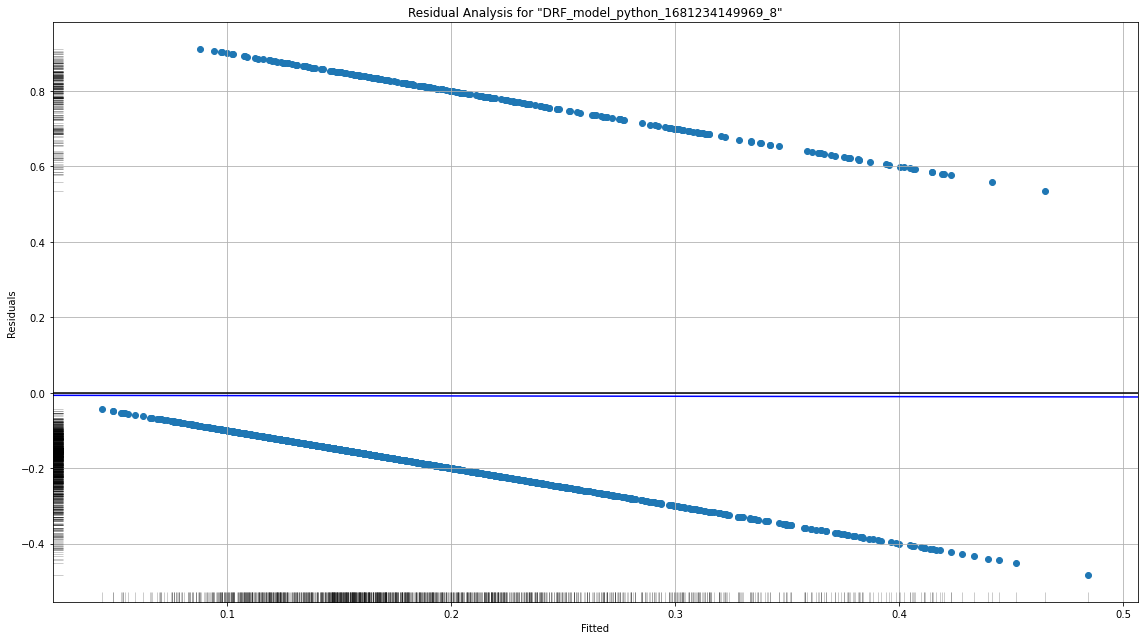

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

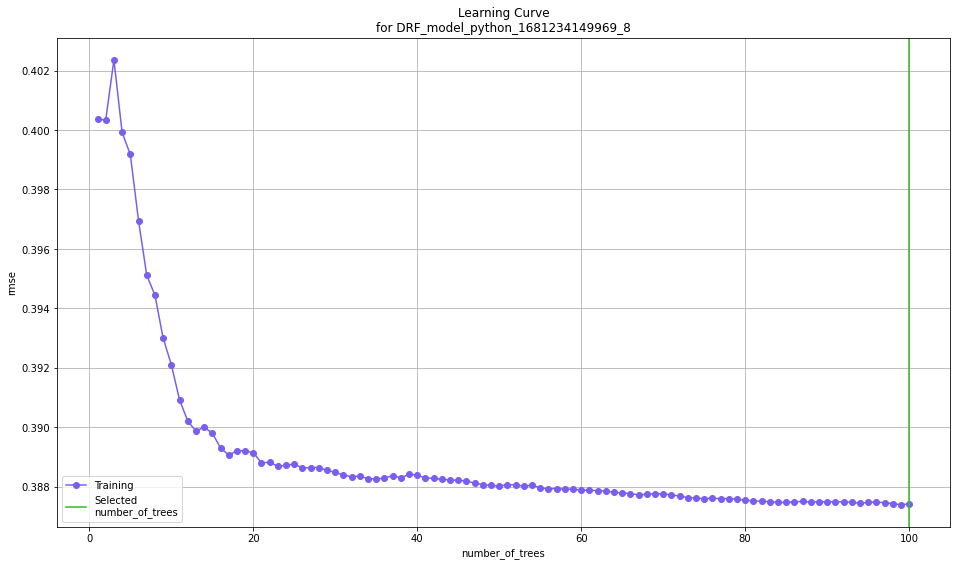

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

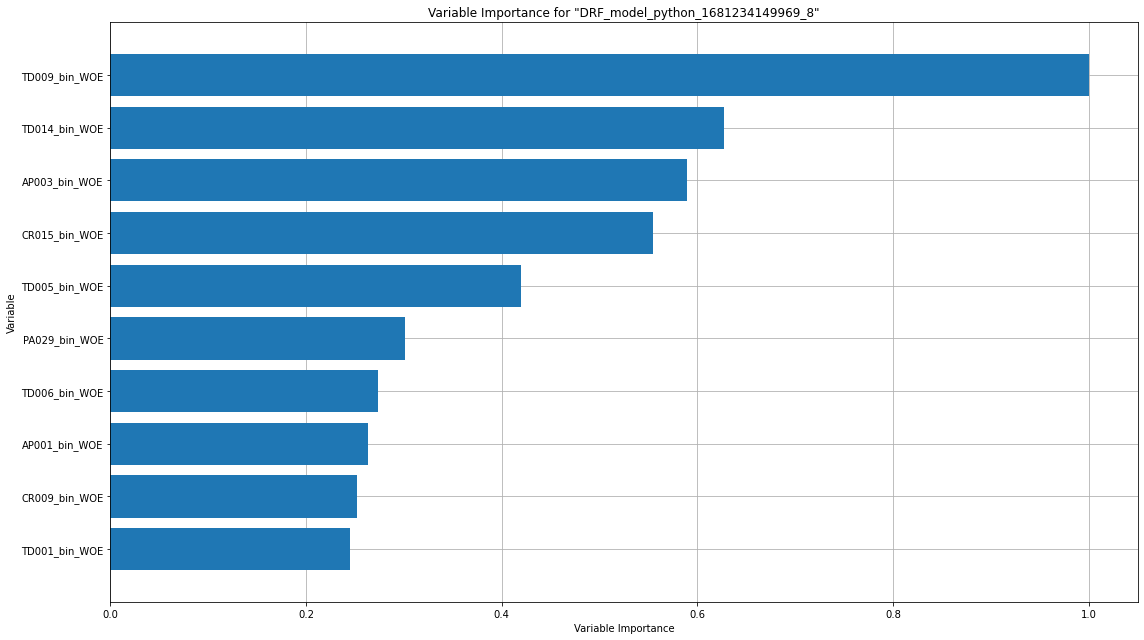

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

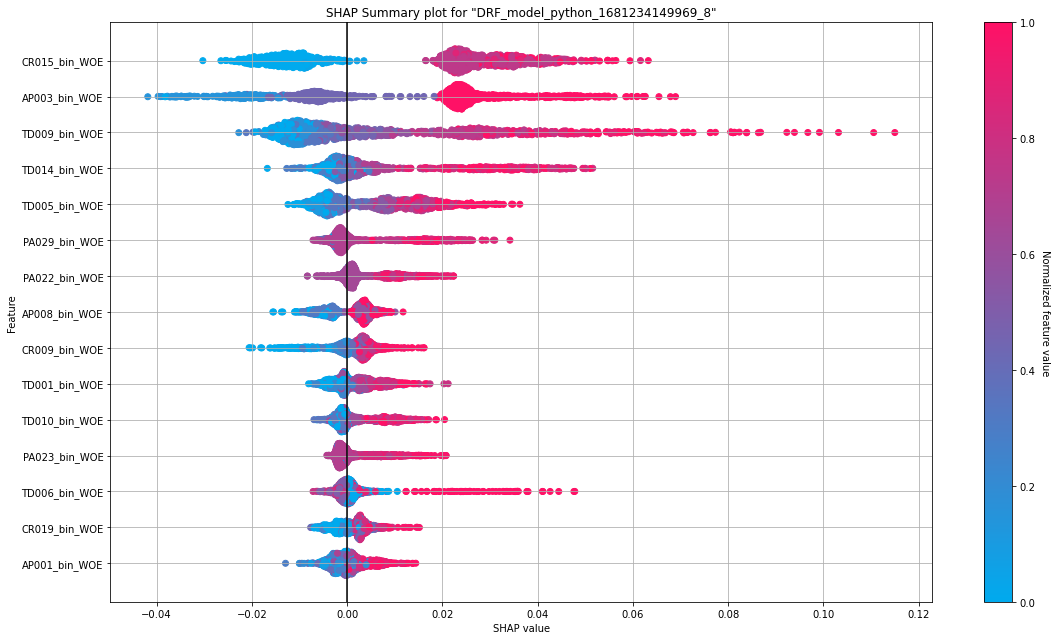

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

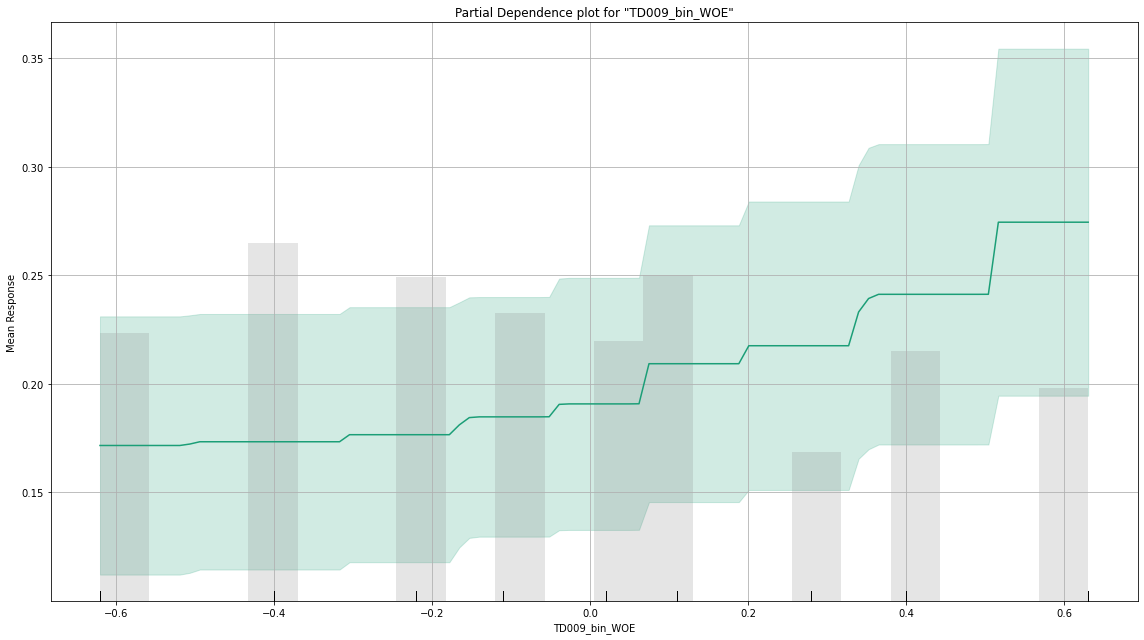

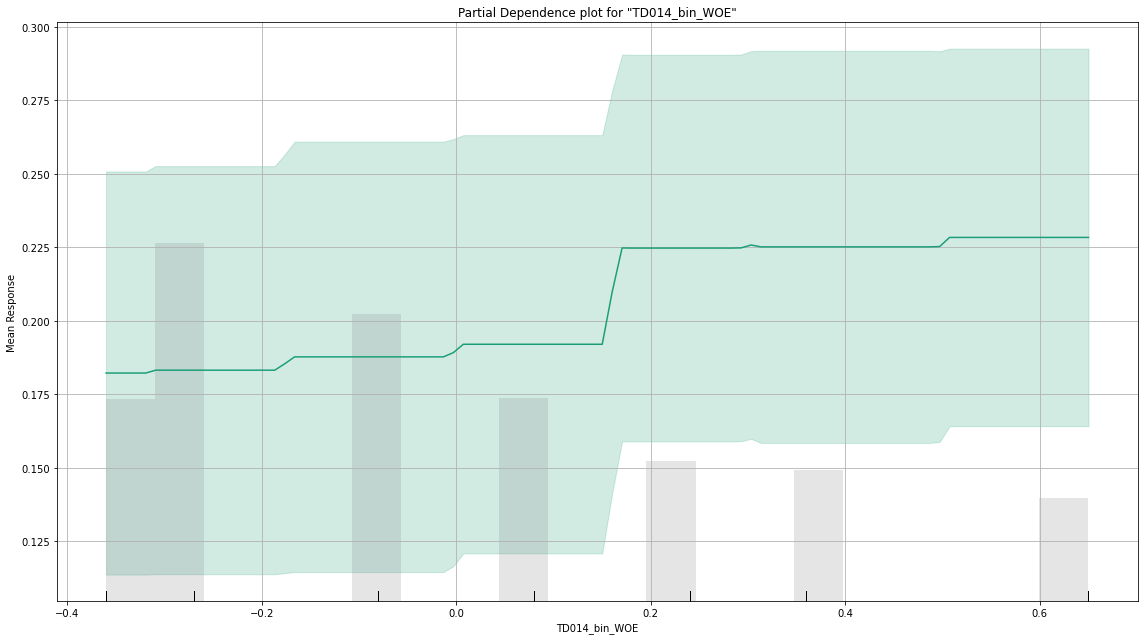

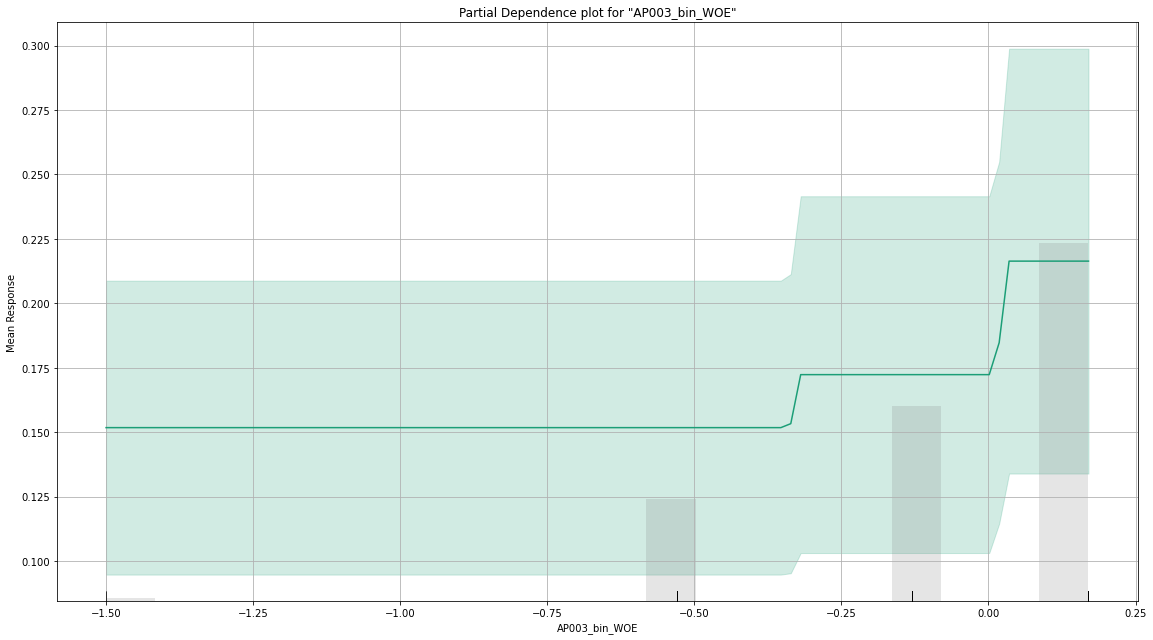

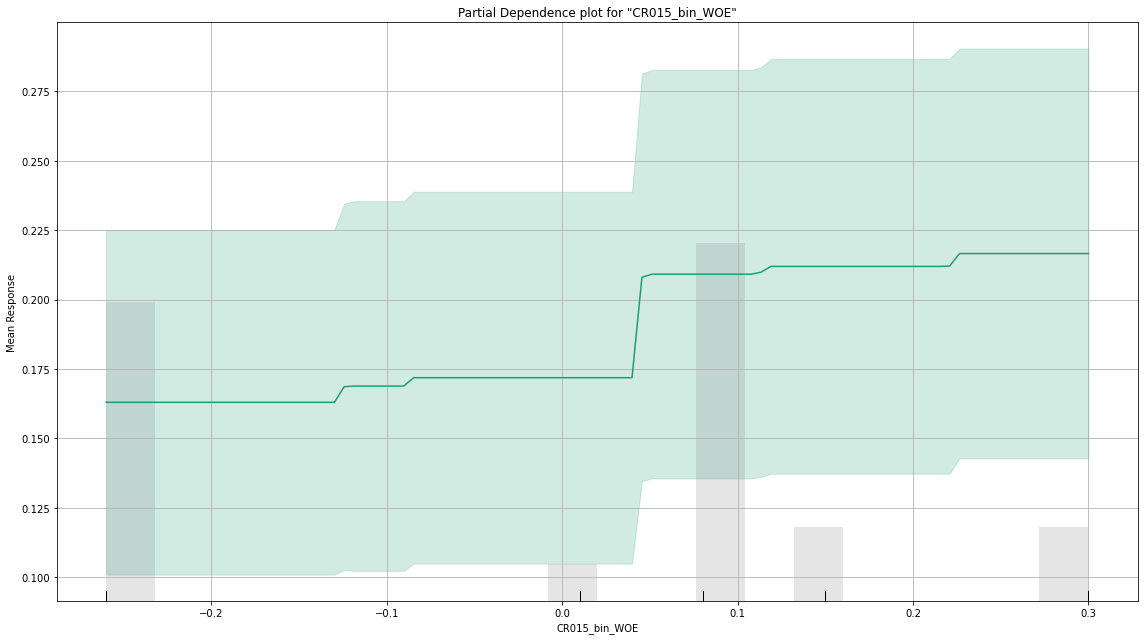

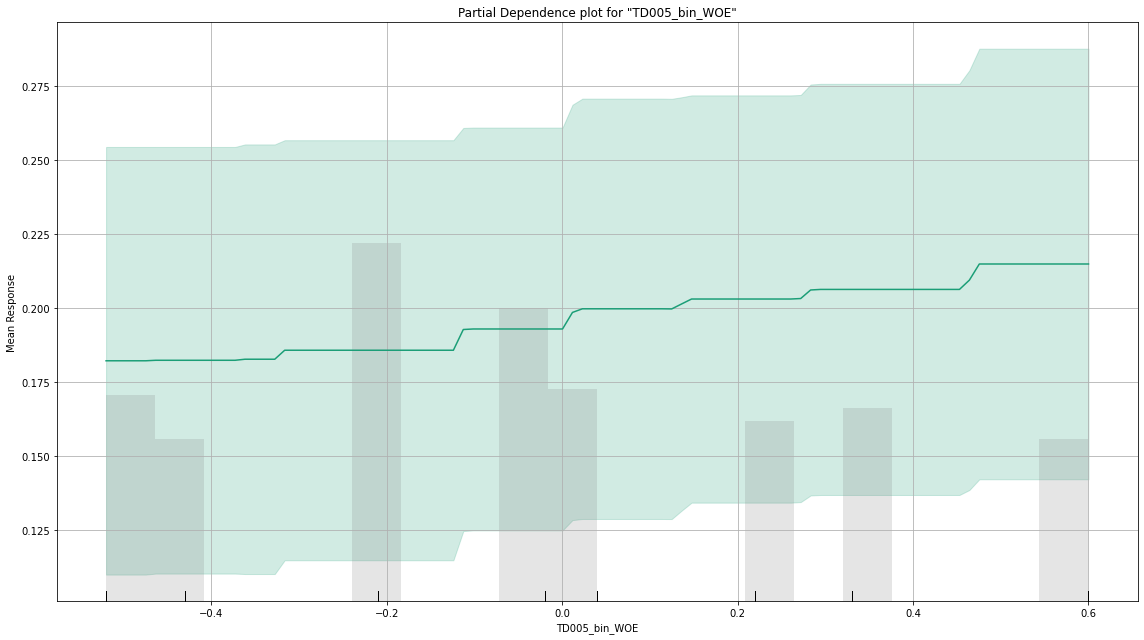

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

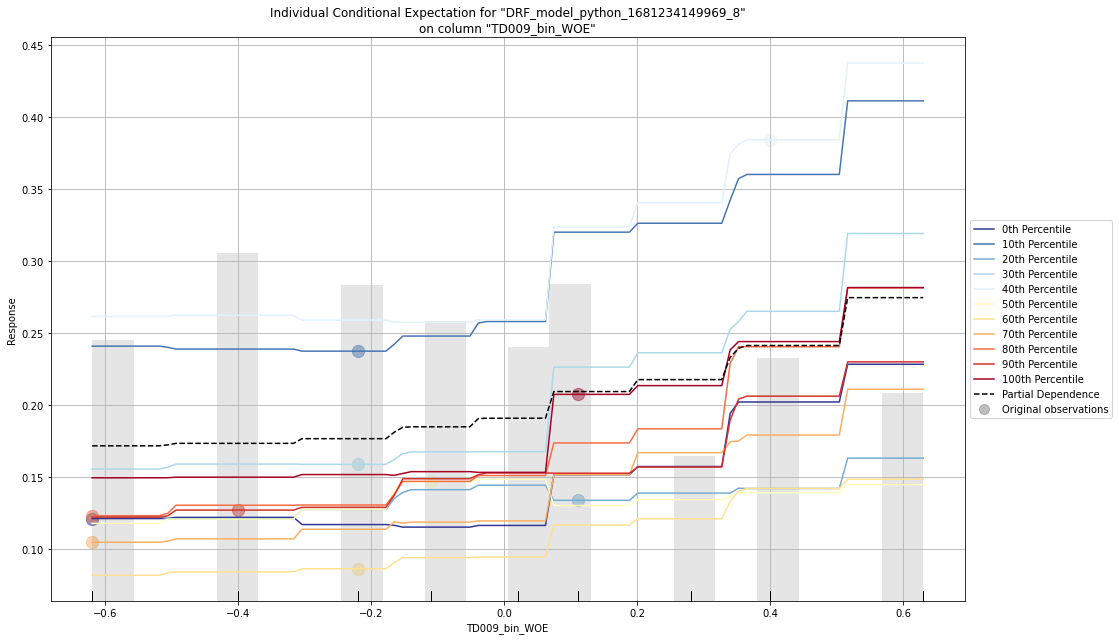

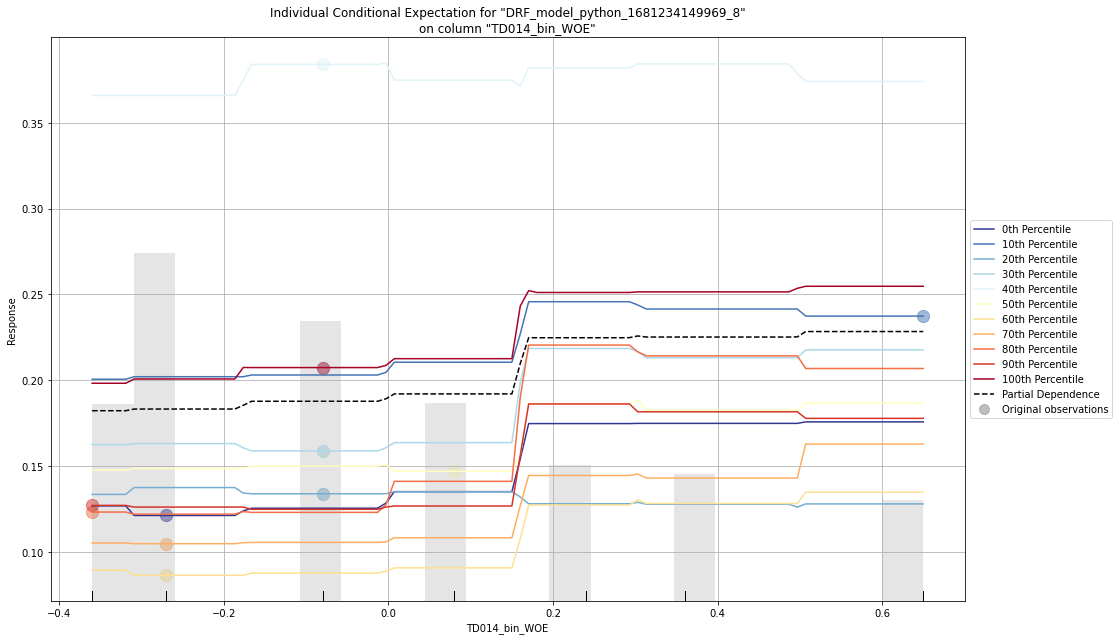

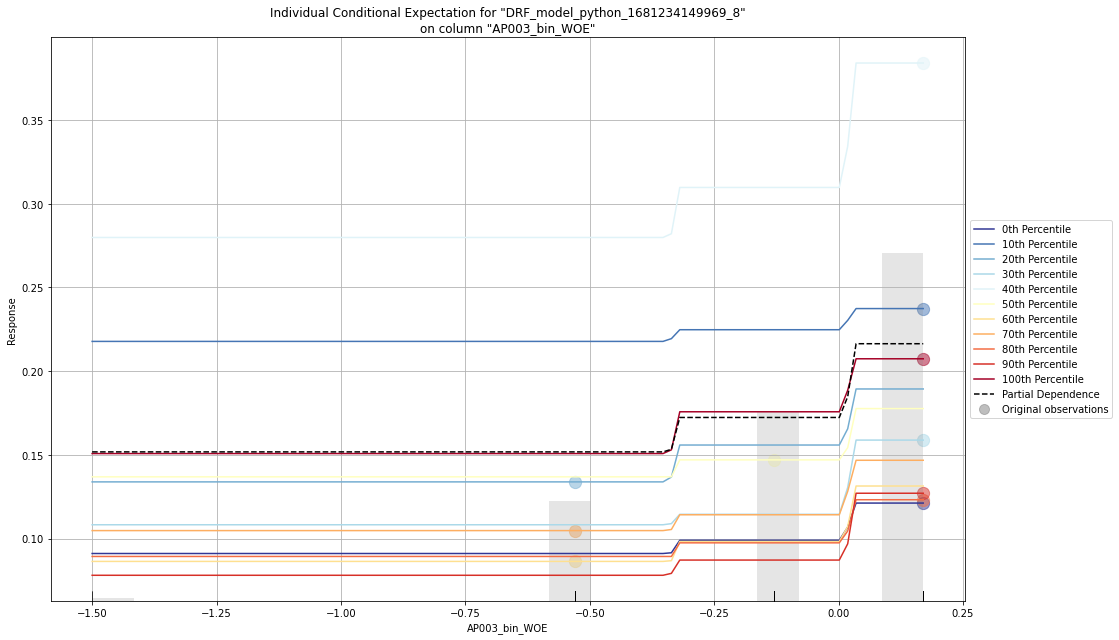

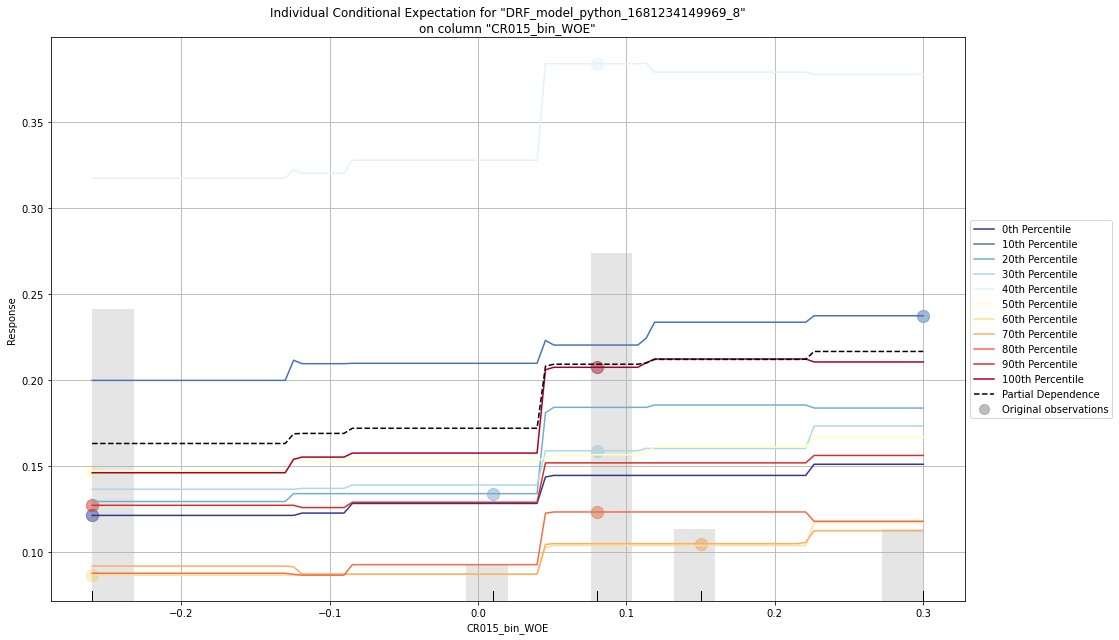

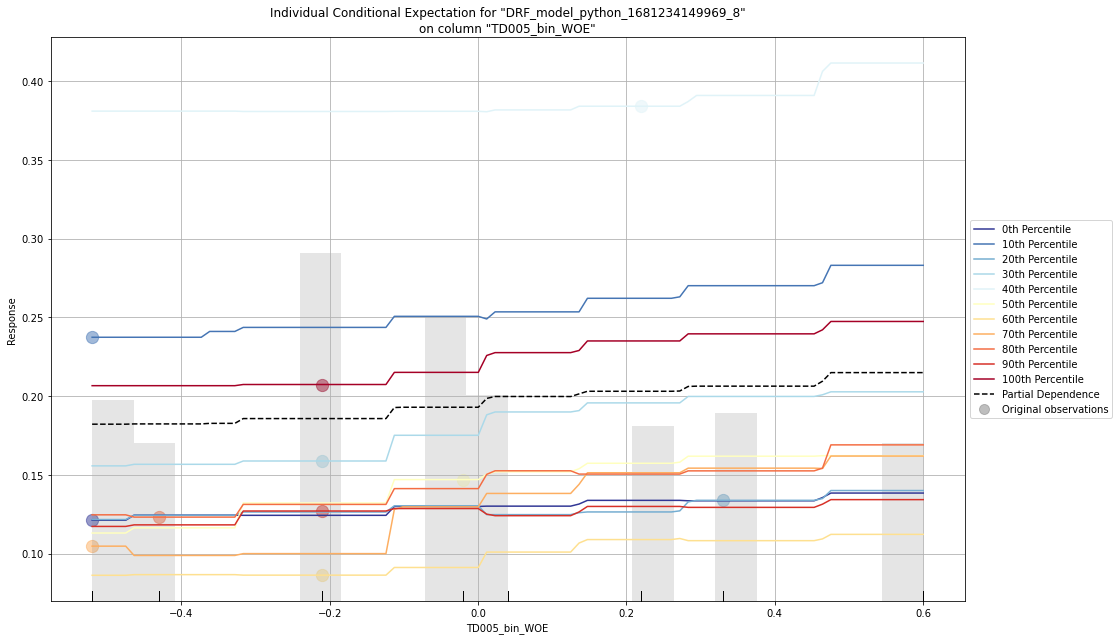

In [44]:
# Explain leader model & compare with all AutoML models
model_explain = rf.explain(test_hex)

### Conclusion

SHAP values and SHAP visualizations help understand not only the importance but also effect of each variable in the model and every individual case.

The summary plot and dependance plot provides us with a global interpretation from a high level and the force plots provide with a much granular understanding ie local interpretation.

Some anomalies may occur with regards to features predicting against the expectation based on observed correlation patterns. These can be exposed by observing the force plots.

- Each feature has a shap value contributing to the prediction.
- The final prediction = the average prediction + the shap values of all features.
- The shap value of a feature can be positive or negative.
- If a feature is positively correlated to the target, a value higher than its own average will contribute positively to the prediction.
- If a feature is negatively correlated to the target, a value higher than its own average will contribute negatively to the prediction.